# Tutorial 2 - AquaHarmonics
The goal of this tutorial is to illustrate a more realistic model of a PTO, including nonlinear power conversion chain. 
It uses the [AquaHarmonics](https://aquaharmonics.com/wec_vis/) device in one degree of freedom in regular waves, models the PTO generator using a motor power loss map and adds realistic constraints, including generator maximum torque and min/max line tension.

This tutorial is comprises two parts, where the second section builds upon the first.

1. [Optimal control with a loss map](#1.-Optimal-control-with-a-loss-map)
2. [Control co-design of line pretension/ballast with non-linear power conversion](#2.-Control-co-design-of-line-pretension/ballast)

![AquaHarmonics device](https://aquaharmonics.com/wec_vis.png)

In [1]:
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import brute

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')
cc = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 1. Optimal control with a loss map

### WEC object
We will go through a number of steps to create a `WEC` object, with we can use to solve for the optimal control trajectory.
See Tutorial 1 for detailed instructions on what is needed to create the `WEC` object.

#### Geometry
First we create a surface mesh for the WEC hull, and quickly visualize the cross-sectional shape of the hull.
The AquaHarmonics hull mesh is already included with WecOptTool, much like the WaveBot mesh in Tutorial 1.
Take a look at the [`geom.py`](https://sandialabs.github.io/WecOptTool/api_docs/wecopttool.geom.html) module if you are interested in seeing how it was created.
Note that the lower cylindrical section of the hull is open to the sea.

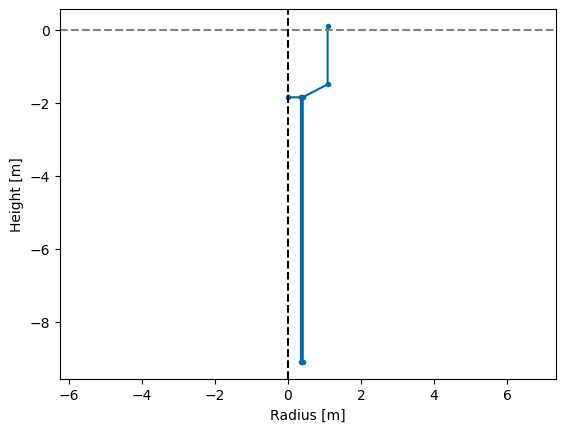

In [2]:
ah_hull = wot.geom.AquaHarmonics()
mesh = ah_hull.mesh(mesh_size_factor=0.25)
_ = ah_hull.plot_cross_section()

Next we create a `FloatingBody` object from the mesh in Capytaine, which we will use to calculate the hydrodynamics.
We can visualize a 3D rendering of the mesh now as well.

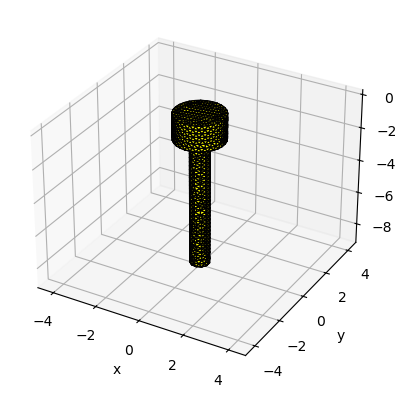

In [3]:
fb = cpy.FloatingBody.from_meshio(mesh, name="AquaHarmonics")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs
fb.show_matplotlib()

#### Hydrostatics and mass
The AquaHarmonics device is positively buoyant (i.e., the buoyancy force is greater than the force due to gravity).
Therefore we will set the rigid-body mass manually (unlike Tutorial 1), but allow the hydrostatic stiffness to be set automatically by run_bem() based on the mesh.
We will also calculate the displaced volume and mass from the mesh (before manually defining the mass of the FloatingBody), which we will need later for defining forces and constraints.

In [4]:
g = 9.81
rho = 1025
fb.center_of_mass = [0, 0, 0]
fb.rotation_center = fb.center_of_mass
displaced_mass = fb.compute_rigid_body_inertia(rho=rho).values # kg
displacement = displaced_mass/rho # m^3

fb.mass = np.atleast_2d(5e3) # kg

### Waves
A regular wave will allow us to get a good initial understanding of the optimal control trajectory.
Note that we need to choose an appropriate fundamental frequency, $f_1$, and number of frequencies, nfreq, to ensure that the wave frequency and harmonic components are within the frequency array we use to calculate the hydrodynamic data.

In [5]:
amplitude = 0.5
wavefreq =  0.24/2 
phase = 30
wavedir = 0

f1 = wavefreq # Hz
nfreq = 10

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

#### Hydrodynamics

Next we will run the boundary element model (BEM) [Capytaine](https://github.com/capytaine/capytaine) to obtain the hydrodynamic coefficients for the hull.
Before running the BEM solver, we must create a set of frequencies at which to perform the calculations.
For WecOptTool, these must be a regularly spaced frequency array.

In [6]:
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

bem_data = wot.run_bem(fb, freq, rho=rho, g=g)

c:\Users\dtgaebe\AppData\Local\miniforge3\envs\wecopttool_dev\Lib\site-packages\capytaine\io\xarray.py:68: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  keys_in_dataset = set(dataset.dims.keys())
The resolution of the mesh 'AquaHarmonics' of the body 'AquaHarmonics_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.81e-01 > λ/8.
The resolution of the mesh 'AquaHarmonics' of the body 'AquaHarmonics_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.81e-01 > λ/8.
The resolution of the mesh 'AquaHarmonics' of the body 'AquaHarmonics_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because 

We can also quickly plot the results to confirm they look reasonable.

[(<Figure size 300x300 with 1 Axes>,
  array([[<Axes: title={'center': 'Heave'}, xlabel='$\\omega$', ylabel='Heave'>]],
        dtype=object)),
 (<Figure size 300x300 with 1 Axes>,
  array([[<Axes: title={'center': 'Heave'}, xlabel='$\\omega$', ylabel='Heave'>]],
        dtype=object)),
 (<Figure size 300x300 with 1 Axes>,
  array([[<Axes: title={'center': 'Heave'}, xlabel='$\\omega$'>]],
        dtype=object))]

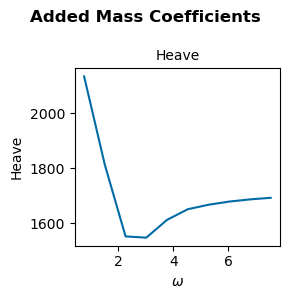

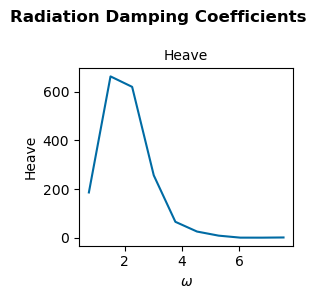

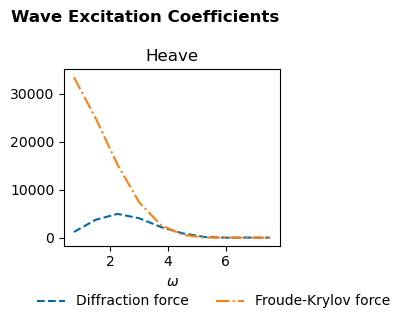

In [7]:
wot.utilities.plot_hydrodynamic_coefficients(bem_data)

#### PTO 
The AquaHarmonics device drive train includes a generator and pneumatic air spring, each of which have distinct gearings relative to linear tether motion as well as finite levels of inertia and friction. 
Take a look at their [interactive visualization](https://aquaharmonics.com/wec_vis/) of the device and PTO system in motion.
Here, we define each of these factors so that they may be subsequently incorporated into our model.

In [8]:
radii = {
    "S1": 0.02, "S2": 0.795, "S3": 0.1595, "S4": 0.200525, "S5": 0.40105, 
    "S6": 0.12575, "S7": 0.103
}

inertias = {
    "Igen": 3.9, "I1": 0.029, "I2": 25.6, "I3": 1.43, "I4": 1.165, "I5": 4.99, 
    "I6": 1.43, "I7": 1.5, "mps": 40
}

friction = {
    "Bgen": 7, "Bdrivetrain": 40, "Bshaft": 40, "Bspring_pulley": 80, 
    "Bpneumatic_spring": 700, "Bpneumatic_spring_static1": 0, 
    "Bpspneumatic_spring_static2": 0
}

airspring = {
    "gamma": 1.4, "height": 1, "diameter": 3, "area": 0.0709676, 
    "press_init": 854e3, "vol_init": 1
}

gear_ratios = {
    "R21": radii['S2']/radii['S1'],
    "R45": radii['S4']/radii['S5'], 
    "R67": radii['S6']/radii['S7'],
    "spring": radii['S6']*(radii['S4']/radii['S5'])
}

inertia_pto = (
    (inertias["Igen"]  + inertias["I1"])*gear_ratios['R21']**2 +
    (inertias['I2'] +inertias['I3'] + inertias['I4']) +
    gear_ratios["R45"]**2 * (
        inertias['I5'] + inertias['I6'] +
        inertias["I7"] * gear_ratios['R67']**2 +
        inertias['mps'] * radii['S6']**2   
    )
)

friction_pto = (
    friction['Bgen']*gear_ratios['R21']**2 + 
    friction['Bdrivetrain'] +
    gear_ratios["R45"]**2 * (
        friction["Bshaft"]+
        friction["Bspring_pulley"]*gear_ratios['R67']**2 +
        friction["Bpneumatic_spring"]*radii['S6']**2
    )
)

##### Generator loss map
The generator used by the AquaHarmonics devices is a motor from a Nissan Leaf.
WecOptTool currently uses loss maps, as efficiency maps are unable to account for losses that occur when the mechanical power is zero (e.g., when the torque is nonzero, but the shaft speed is zero).
Thus, we use an [approximate model for the losses](https://en.wikipedia.org/wiki/Joule_heating) in this example.

In [9]:
winding_resistance = 0.4
torque_coefficient = 1.5

def power_loss(speed, torque):
    return winding_resistance * (torque / torque_coefficient)**2 

In addition to the loss data, the generator has some limitations, which we can capture in our model.
Specifically, this generator has the following limits:

 * Maximum rotational speed: 10,000 rpm
 * Maximum torque: 300 Nm
 * Maximum power: 80 kW

In [10]:
rot_max = 10000*2*np.pi/60 # rad/s
torque_max = 300 # Nm
power_max = 80e3 # W

Finally, we can plot the motor power loss surface to see how it looks.
Here, the independent variables are the motor speed (in rad/s) and the motor torque (in Nm).
Note that we limit the plot by the power limit.

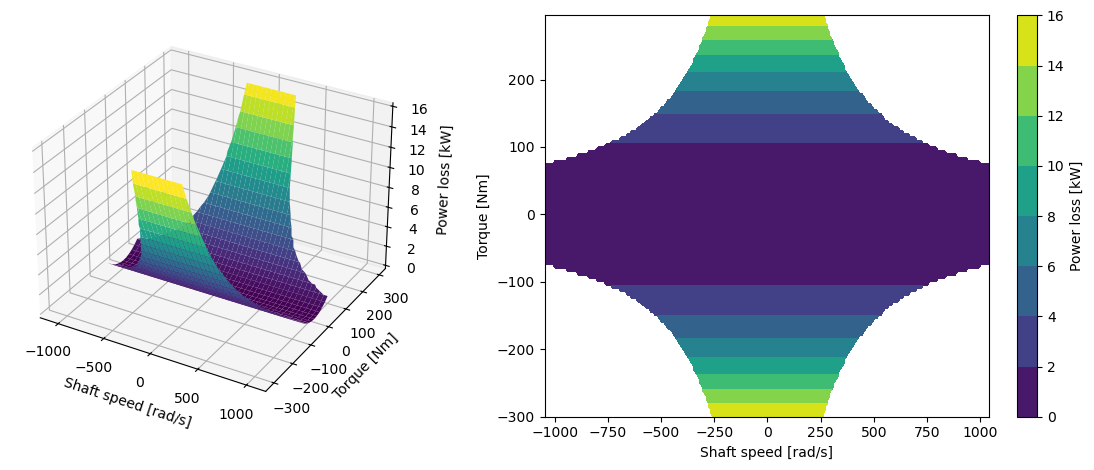

In [11]:
x = np.arange(-1*rot_max, 1*rot_max, 10)
y = np.arange(-1*torque_max, 1.0*torque_max, 5)
X, Y = np.meshgrid(x, y)
Z = power_loss(X, Y).copy()/1e3
Z[np.abs(X*Y) > power_max] = np.NaN  # cut off area outside of power limit

fig = plt.figure(figsize=plt.figaspect(0.4))
ax = [fig.add_subplot(1, 2, 1, projection="3d"),
      fig.add_subplot(1, 2, 2)]

ax[0].plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0)
ax[0].set_xlabel('Shaft speed [rad/s]')
ax[0].set_ylabel('Torque [Nm]')
ax[0].set_zlabel('Power loss [kW]')

contour = ax[1].contourf(X, Y, Z, cmap=cm.viridis)
plt.colorbar(contour, label="Power loss [kW]")
ax[1].set_xlabel('Shaft speed [rad/s]')
ax[1].set_ylabel('Torque [Nm]')

plt.tight_layout()

##### PTO object
Using both the parametric kinematics (gear ratios) and the motor power loss map, we can now create a PTO object that will be inserted in our WEC object.
Note that the friction and inertia effects will be included as additional forces.
By defining the PTO object in this way, we will be able to more clearly distinguish the power generating forces from other effects (e.g., friction).

In [12]:
name = ["PTO_Heave",]
gear_ratio_generator = gear_ratios['R21']/radii['S3']
kinematics = gear_ratio_generator*np.eye(ndof)
controller = None
nstate_opt = 2*nfreq
pto_impedance = None
pto = wot.pto.PTO(
    ndof, kinematics, controller, pto_impedance, power_loss, name
)

#### Additional Forces
Beyond hydrodynamic loading, this model needs to account for these additional phenomena:

* **Buoyancy, gravity and pretension** - While buoyancy and gravity are often lumped together in similar models, we will keep them separate here.
This is useful because the AquaHarmonics devices has a pretension force, so the buoyancy and gravity forces are not balanced at the neutral position and there is a pretension force from the tether/air spring.
* **Passive PTO forces** - Inertia forces due to finite rigid body inertia of gears and friction forces within the drive train are captured by this function.
* **PTO line force** - The total force imposed on the WEC from its tether is the sum of the PTO force due to action by the generator and the pretension force from the air spring.
The generator torque will be our control state for which we will derive the optimal trajectory.

In [13]:
def f_buoyancy(wec, x_wec, x_opt, waves, nsubsteps=1):
    """Only the zeroth order component (doesn't include linear stiffness)"""
    return displacement * rho * g * np.ones([wec.ncomponents*nsubsteps, wec.ndof])

def f_gravity(wec, x_wec, x_opt, waves, nsubsteps=1):
    return -1 * wec.inertia_matrix.item() * g * np.ones([wec.ncomponents*nsubsteps, wec.ndof])

def f_pretension_wec(wec, x_wec, x_opt, waves, nsubsteps=1):
    """Pretension force as it acts on the WEC"""
    f_b = f_buoyancy(wec, x_wec, x_opt, waves, nsubsteps) 
    f_g = f_gravity(wec, x_wec, x_opt, waves, nsubsteps)
    return  -1*(f_b+f_g)

def f_pto_passive(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos = wec.vec_to_dofmat(x_wec)
    vel = np.dot(wec.derivative_mat,pos)
    acc = np.dot(wec.derivative_mat, vel)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    spring = -(gear_ratios['spring']*airspring['gamma']*airspring['area']*
              airspring['press_init']/airspring['vol_init']) * pos
    f_spring = np.dot(time_matrix,spring)
    fric = -(friction_pto  + 
                friction['Bpneumatic_spring_static1']*
                gear_ratios['spring']) * vel
    f_fric = np.dot(time_matrix,fric)
    inertia = inertia_pto * acc
    f_inertia = np.dot(time_matrix,inertia)
    return f_spring + f_fric + f_inertia

def f_pto_line(wec, x_wec, x_opt, waves, nsubsteps=1):
    f_pto = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    f_pre = f_pretension_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_pto + f_pre

f_add = {'PTO': f_pto_line,
         'PTO_passive': f_pto_passive,
         'buoyancy': f_buoyancy,
         'gravity': f_gravity}

#### Constraints
A number a constraints need to be imposed to reflect finite limitation of the drive train hardware.
Each of these will be implemented as inequality constraints that will be passed to the numerical optimization solver.

Note that we are imposing the constraints at more points than the dynamics by setting `nsubsteps>1`.
This ensures that the constraint is properly maintained (see the [Theory](https://sandialabs.github.io/WecOptTool/theory.html) documentation for more details).

 * **Peak torque** - The absolute motor torque cannot exceed this value.
 * **Maximum rotational speed** - The absolute motor speed cannot exceed this value.
 * **Maximum power** - The maximum mechanical power (i.e., product of torque and velocity) cannot exceed this value.
 * **Minimum line tension** - In addition to these limitations on the hardware, we will also constrain the solution to prevent the tether tension from going below a certain threshold.
 We absolutely cannot allow the line tension to be less than zero, or else it will go slack.
 In practice, it is prudent to set some nonzero limit for the tether tension.
 * **Mean torque** - While solutions with an nonzero mean positions may indeed be valid, we want to rely on a single calculation of the linear hydrodynamics at a mean position of 0.
 To avoid violating this approach, we will constrain the mean WEC position to zero.

In [14]:
# Generator constraints
torque_peak_max = 280  # Nm
rot_speed_max = 10000*2*np.pi/60  # rad/s

# Mooring/PTO line constraint
min_line_tension = -1000

nsubsteps = 2

def const_peak_torque_pto(wec, x_wec, x_opt, waves):
    torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps)
    return torque_peak_max - np.abs(torque.flatten())

def const_speed_pto(wec, x_wec, x_opt, waves):
    rot_vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return rot_speed_max - np.abs(rot_vel.flatten())

def const_power_pto(wec, x_wec, x_opt, waves):
    power_mech = (
        pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) *
        pto.force(wec, x_wec, x_opt, waves, nsubsteps)
    )
    return power_max - np.abs(power_mech.flatten())

def constrain_min_tension(wec, x_wec, x_opt, waves):
    total_tension = -1*f_pto_line(wec, x_wec, x_opt, waves, nsubsteps)
    return total_tension.flatten() + min_line_tension

def zero_mean_pos(wec, x_wec, x_opt, waves):
    return x_wec[0]

constraints = [
    {'type': 'ineq', 'fun': constrain_min_tension,},
    {'type': 'ineq', 'fun': const_peak_torque_pto,},
    {'type': 'ineq', 'fun': const_speed_pto,},
    {'type': 'ineq', 'fun': const_power_pto,},
    {'type': 'eq', 'fun': zero_mean_pos},
]

#### WEC object
Finally, we can use all the different components developed thus far to construct the `WEC` object:

 * **BEM data** - defines the hydrostatics and hydrodynamics of the hull
 * **Constraints** - limitations on the hardware (max power, max torque, etc.) and the constraint to prevent the tether from going slack
 * **Additional forces** - this captures all of the forces on the WEC that are not due to the interaction between the hull and water (PTO, etc.)

In [15]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints = constraints,
    f_add = f_add,
)

### Objective function
To drive the solution of the optimal control trajectory, we will optimize the average electrical power from the PTO.

In [16]:
obj_fun = pto.average_power

### Solve
Finally, we solve for the optimal control trajectory.
To ensure the numerical optimization problem is well-scaled, we set specific scaling factors for the WEC position (`scale_x_wec`), the PTO force (`scale_x_opt`), and objective function (`scale_obj`).
We will also set the [maximum iteration and objective function tolerance for the optimization solver](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html).
This step typically takes about 30s.

In [17]:
scale_x_wec = 1e1
scale_x_opt = 50e-2
scale_obj = 1e-3

options = {'maxiter': 200, 'ftol': 1e-8}

results = wec.solve(
    waves,
    obj_fun,
    nstate_opt,
    x_wec_0=np.ones(wec.nstate_wec) * 1e-3,
    x_opt_0=np.ones(nstate_opt) * 1e-3,
    optim_options=options,
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)

print(f'Optimal average power: {results[0].fun/1e3:.2f} kW')

C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:754: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5766544063268666
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimal average power: -1.58 kW


### Post-process and plotting
Next, we post-process the results to allow us to more easily visualize them in a series of plots.

In [18]:
wec_fdom, wec_tdom = wec.post_process(results[0], waves.sel(realization=0), nsubsteps=nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results[0], waves.sel(realization=0), nsubsteps=nsubsteps)

We can inspect each of these `xarray Dataset` objects for more details.
As an example the post-processed WEC time-domain results include the following:

In [19]:
wec_tdom

<xarray.Dataset>
Dimensions:         (influenced_dof: 1, time: 40, type: 9, wave_direction: 1)
Coordinates:
  * influenced_dof  (influenced_dof) <U5 'DOF_0'
    realization     int32 0
  * time            (time) float64 0.0 0.2083 0.4167 0.625 ... 7.708 7.917 8.125
    omega           float64 7.54
    freq            float64 1.2
    period          float64 0.8333
  * type            (type) object 'radiation' 'friction' ... 'gravity'
  * wave_direction  (wave_direction) float64 0.0
Data variables:
    pos             (influenced_dof, time) float64 0.4257 0.4801 ... 0.3599
    vel             (influenced_dof, time) float64 0.2902 0.2343 ... 0.3364
    acc             (influenced_dof, time) float64 -0.2669 -0.2887 ... -0.1997
    force           (influenced_dof, type, time) float64 504.3 ... -4.905e+04
    wave_elev       (wave_direction, time) float64 0.433 0.3886 ... 0.4668
Attributes:
    time_created_utc:  2024-04-27 18:31:58.950797

#### Time histories
We will now generate a series of time history plots:

 * **Excitation force and velocity** - Looking at the velocity of the WEC along with the excitation force is useful as we expect the two of these to be in phase *when maximizing mechanical power and in the absence of constraints.*
 * **PTO and total mooring tether force** - Since we constrained the PTO force in order to maintain a minimum mooring tether tension, it is useful to visualize these values to confirm that the constraint was properly enforced.
 * **Generator torque** - Similarly, we constrained the maximum torque from the generator
 * **Power** - We can look at both electrical and mechanical power along with the constraint on mechanical power.

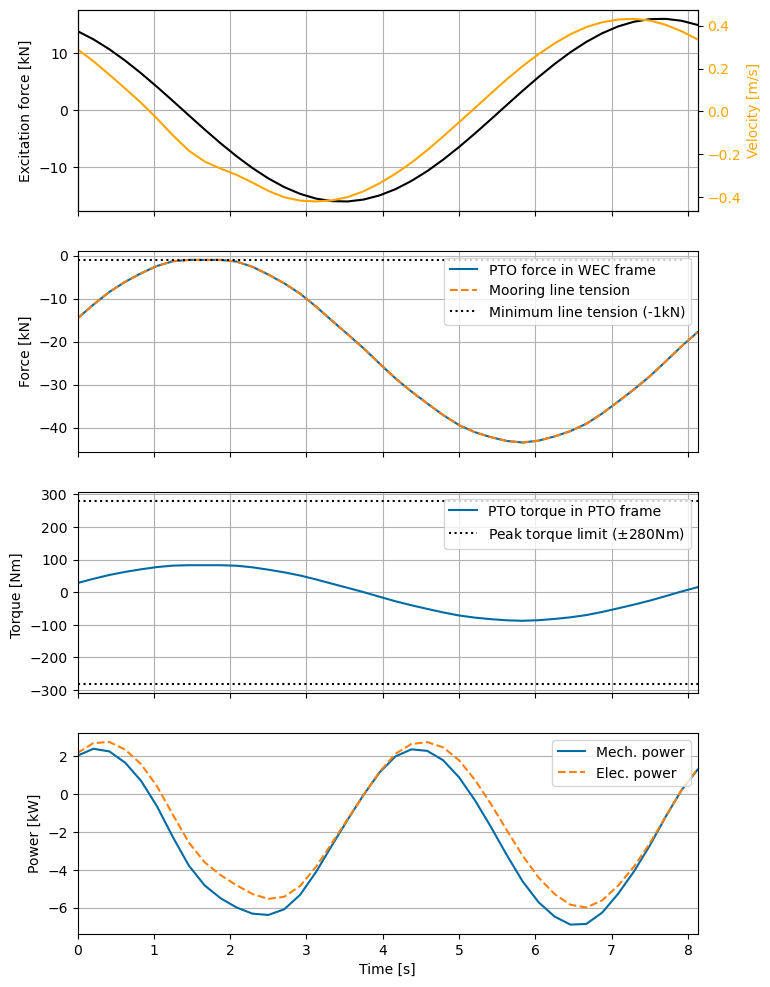

In [20]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 12))

# Excitation and velocity
ax1 = ax[0].twinx()
force_excitation = wec_tdom.force.sel(type=['Froude_Krylov', 'diffraction'])
force_excitation = force_excitation.sum('type')/1e3
force_excitation.plot(ax=ax[0], color='k')
wec_tdom.vel.plot(ax=ax1, color='orange')
ax1.set_ylabel('Velocity [m/s]', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.set_title('')
ax1.autoscale(enable=True, axis='x', tight=False)
ax[0].set_ylabel('Excitation force [kN]')

# Forces
(wec_tdom.force.sel(type='PTO')/1e3).plot(
    ax=ax[1], 
    label='PTO force in WEC frame',
)
x_wec, x_opt = wot.decompose_state(results[0].x, ndof=ndof, nfreq=nfreq)
ax[1].plot(
    wec.time_nsubsteps(nsubsteps),
    f_pto_line(wec, x_wec, x_opt, waves, nsubsteps)/1e3,
    linestyle='dashed', 
    label='Mooring line tension',
)
ax[1].plot(
    wec.time, 
    min_line_tension * np.ones(wec.time.shape) / 1e3,
    linestyle='dotted', 
    color='black',
    label=f'Minimum line tension ({min_line_tension/1e3:.0f}kN)',
)
ax[1].axhline(y=0, xmin=0, xmax=1, color='0.75', linewidth=0.5)
ax[1].set_ylabel('Force [kN]')
ax[1].legend(loc=1)

# Torque
pto_tdom.force.plot(
    ax=ax[2], 
    linestyle='solid',
    label='PTO torque in PTO frame',
)
ax[2].plot(
    pto_tdom.time, 
    1*torque_peak_max * np.ones(pto_tdom.time.shape),
    color='black', 
    linestyle='dotted',
    label=f'Peak torque limit ($\pm${torque_peak_max}Nm)',
)
ax[2].plot(
    pto_tdom.time, 
    -1*torque_peak_max * np.ones(pto_tdom.time.shape), 
    color='black', 
    linestyle='dotted',
)
ax[2].set_ylabel('Torque [Nm] ')
ax[2].legend(loc='upper right',)

# Power
(pto_tdom['power'].sel(type='mech')/1e3).plot(ax=ax[3], label='Mech. power')
(pto_tdom['power'].sel(type='elec')/1e3).plot(ax=ax[3], linestyle='dashed', 
                             label="Elec. power")
ax[3].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax[3].legend(loc='upper right')
ax[3].set_title('')
ax[3].set_ylabel('Power [kW]')

for axi in ax:
    axi.set_title('')
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)

#### Generator torque vs. shaft speed
An important factor in this study was the motor loss map that we defined for the generator.
We can visualize how the optimal control trajectory looks in state-space along with that loss map.

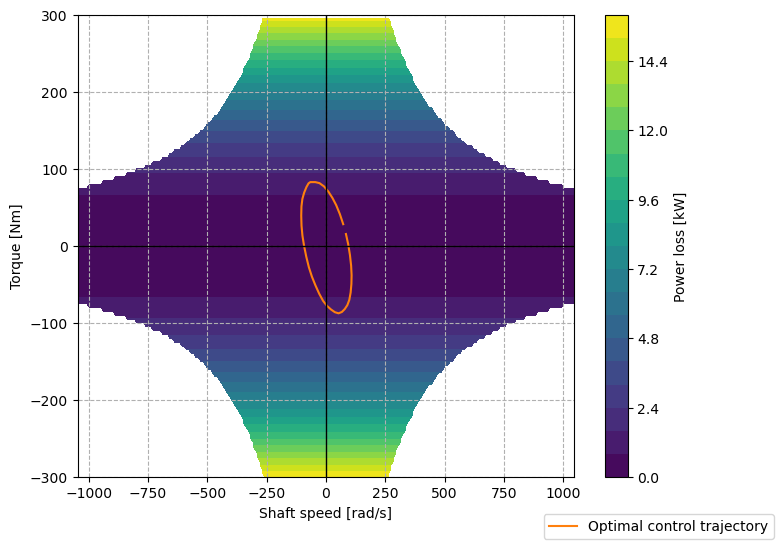

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(pto_tdom.vel, pto_tdom.force, color=cc[1], label='Optimal control trajectory')
contour = ax.contourf(X, Y, Z, levels=20, cmap=cm.viridis)
plt.colorbar(contour, label="Power loss [kW]")
ax.grid(which='major', linestyle='--')
ax.axvline(0, color='k', lw=1)
ax.axhline(0, color='k', lw=1)
ax.set_ylim([-torque_max, torque_max])
ax.set_ylabel('Torque [Nm]')
ax.set_xlabel('Shaft speed [rad/s]')
fig.legend(loc='lower right')

## 2. Control co-design of line pretension/ballast
[Part 1](#1.-Optimal-control-with-a-loss-map) of this tutorial set up the model and solved for the optimal control trajectory of a single fixed device design.
We now will do control co-design to answer a real, practical question the designers have about the AquaHarmonics design:
**How big of an effect does the mass vs. line pretension have on the output power?** 

To do this study we will define the maximum mass as the mass that results in the pretension being equal to the minimum pretension, and define that as a mass ratio of 1.
Note that this maximum mass is slightly smaller than the displaced mass, in order to maintain some positive net buoyancy and thus achieve the minimum line tension.
We will then consider different designs consisting of different mass ratios and see how the output power varies. 
For each design the optimal controller for that design will be found, as in Part 1.

### Problem setup
The first step is to create a function that encapsulates solving for the optimal control trajectory to maximize power (i.e., Part 1 of this tutorial) to nest within an outer optimization loop.
This is similar to part 3 of Tutorial 1, except we now vary the mass ratio instead of the WEC hull radius.
To accomplish this, we will create a function which takes the mass fraction as an input and returns the average electrical power as an output.
We consider the same regular wave operational condition used in Part 1.

In [22]:
global max_torque 
max_torque = []

def design_obj_fun(x):
    global n
    n += 1

    # Unpack geometry variables
    mass_ratio = x[0]
    mass_var = mass_ratio * max_mass
    bem_data['inertia_matrix'] = mass_var
    
    # update WEC 
    wec_mass = wot.WEC.from_bem(
        bem_data,
        constraints = constraints,
        friction = None,
        f_add = f_add,
    )

    # Solve
    print(f'\nRun {n} of {N+1}: Mass ratio: {mass_ratio:.2f}')
    res = wec_mass.solve(
        waves, 
        obj_fun, 
        nstate_opt, 
        optim_options=options, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj)
    opt_average_power = res[0].fun
    print(
        f'* Mass: {mass_var:.2f} kg\n' +
        f'* Optimal average electrical power: {opt_average_power/1e3:.2f} kW' 
    )

    # wec_fdom, wec_tdom = wec_mass.post_process(res, waves, nsubsteps=nsubsteps)
    global max_torque 
    x_wec, x_opt = wot.decompose_state(res[0].x, ndof=ndof, nfreq=nfreq)
    max_torque.append(np.max(f_pto_line(wec_mass, x_wec, x_opt, waves.sel(realization=0), nsubsteps)))
    
    return res[0].fun

### Solve
We can now pass our function to an optimization algorithm of our choice to determine the optimal mass ratio.
Here, because the problem is fairly small and it is instructive to see the trends in the design space, we will use a [brute force optimization algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html) to evaluate 7 values of mass ratio between 0.3 and 1.0.
Note that this step will take some time to complete.

In [23]:
# define range
min_ten = -1000
max_mass = (min_ten/g + displaced_mass).item()
global n; n = 0 
global N; N = 7 
min_mass_ratio = 0.3
max_mass_ratio = 1.0
mass_vals = np.linspace(min_mass_ratio, max_mass_ratio, N, endpoint=False)
ranges = (slice(
    mass_vals[0], mass_vals[-1]+np.diff(mass_vals)[0], np.diff(mass_vals)[0]
    ),
)

# solve
res = brute(func=design_obj_fun, ranges=ranges, full_output=True,  finish=None)

C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:754: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):



Run 1 of 8: Mass ratio: 0.30


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5276249396693873
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
* Mass: 2131.86 kg
* Optimal average electrical power: -1.53 kW

Run 2 of 8: Mass ratio: 0.40


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:754: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.540407944520902
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
* Mass: 2842.48 kg
* Optimal average electrical power: -1.54 kW

Run 3 of 8: Mass ratio: 0.50


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:754: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5532841799457533
            Iterations: 38
            Function evaluations: 39
            Gradient evaluations: 38
* Mass: 3553.10 kg
* Optimal average electrical power: -1.55 kW

Run 4 of 8: Mass ratio: 0.60


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:754: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5662536052234297
            Iterations: 59
            Function evaluations: 59
            Gradient evaluations: 59
* Mass: 4263.72 kg
* Optimal average electrical power: -1.57 kW

Run 5 of 8: Mass ratio: 0.70


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:754: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5772429329595221
            Iterations: 64
            Function evaluations: 64
            Gradient evaluations: 64
* Mass: 4974.34 kg
* Optimal average electrical power: -1.58 kW

Run 6 of 8: Mass ratio: 0.80


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:754: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4596663030670445
            Iterations: 68
            Function evaluations: 69
            Gradient evaluations: 68
* Mass: 5684.96 kg
* Optimal average electrical power: -1.46 kW

Run 7 of 8: Mass ratio: 0.90


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:754: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.037331110487353
            Iterations: 68
            Function evaluations: 69
            Gradient evaluations: 68
* Mass: 6395.58 kg
* Optimal average electrical power: -1.04 kW

Run 8 of 8: Mass ratio: 1.00


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:754: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0488698068110836e-16
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
* Mass: 7106.20 kg
* Optimal average electrical power: 0.00 kW


### Results
The following plot shows the average electrical power (blue) for each of the seven designs considered along with the mean position of the device.
As the mass ratio is decreased (i.e., ballast removed), the generated power increases -- recall that negative power is power absorbed.
In this wave, the most power is generated when the mass fraction is 0.7.
This is a scenario when the ballast is such that the total rigid body mass is 70% of the maximum, which allows for a pretension that is approximately 21 times the minimum pretension.

As the mass fraction is increased, pretension approaches the minimum line tension.
At the limit (mass fraction of unity), the WEC can produce no power, as any action by the motor would slack the mooring line (recall that we forced the solution be symmetric).
Recall from [the results in Part 1](#time-histories) that we observed the motor torque saturating to avoid violating the minimum line tension constraint.
The red curve corresponding to the y-axis on the right-hand side of the plot shows the minimum absolute line tension.
We can see that for mass fractions equal to and greater than 0.7 the line tension reaches the minimum value, thus bringing that constraint into effect and limiting the generated power.

Below a mass fraction of 0.7, we see a slight decrease in generated power.
As we decrease the mass ($m$), we are increasing the natural frequency ($\omega_n$), and increasingly detuning the device with respect to the incoming waves.

$$
\omega_n = \sqrt{\frac{k}{m}}
$$

Thus we have at least two competing factors (maintaining the minimum line tension vs. aligning the natural frequency of the device to incoming waves), that produce the result seen below.

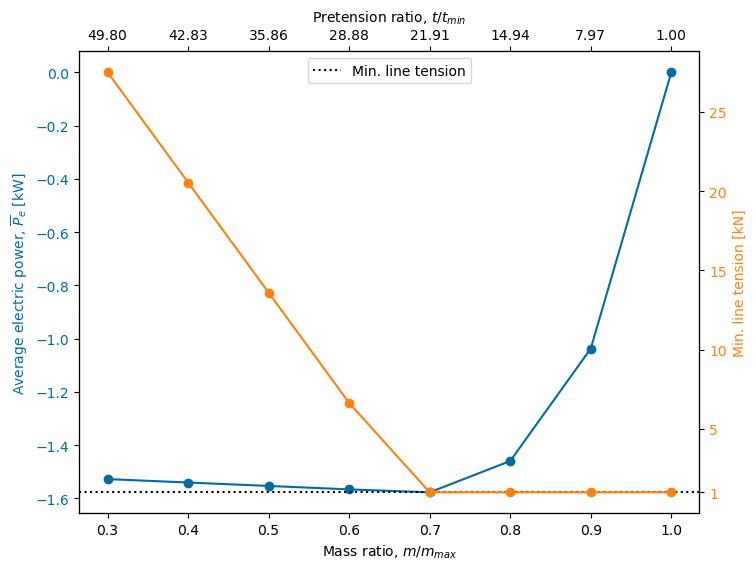

In [24]:
cc = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(res[2], res[3]/1e3, 'o-', color=cc[0])
ax.set_xlabel("Mass ratio, $m/m_{max}$")
ax.set_ylabel("Average electric power, $\overline{P}_e$ [kW]", color=cc[0])
ax.tick_params(axis='y', labelcolor=cc[0])

# second tick
new_tick_locations = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
def tick_function(x):
    mass = np.array(x) * max_mass 
    pretension_ratio = -1*g*(displaced_mass - mass) / min_line_tension
    return [f"{tr:.2f}" for tr in np.squeeze(pretension_ratio)]
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel("Pretension ratio, $t/t_{min}$")

ax3 = ax.twinx()
ax3.axhline(-1*min_line_tension/1e3, linestyle='dotted', color='black',
            label='Min. line tension')
ax3.plot(res[2], np.abs(max_torque)/1e3, 'o-', color=cc[1])
ax3.set_ylabel("Min. line tension [kN]", color=cc[1])
ax3.tick_params(axis='y', labelcolor=cc[1])
ax3.set_yticks([1, 5, 10, 15, 20, 25])
ax3.legend(loc=9)